In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision 
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
from tqdm import tqdm


In [2]:
def conv(channels_in, channels_out): 
    return nn.Conv2d(channels_in, channels_out, kernel_size = 3, stride = 1, padding = 'same', bias = False)

def pool(): 
    return nn.AvgPool2d(kernel_size = 2, stride = 2)

def conv1x1(channels_in, channels_out): 
    return nn.Conv2d(channels_in, channels_out, kernel_size = 1, stride = 1, padding = 'same')

def bn(channels_in): 
    return nn.BatchNorm2d(channels_in)

def relu():
    return nn.ReLU(inplace=True)

def up():
    return nn.Upsample(scale_factor = 2, mode='bilinear')

def dropout(rate):
    return nn.Dropout(rate)

In [3]:
class Layer(nn.Sequential):
    def __init__(self, channels):
        super(Layer, self).__init__()
        self.add_module('norm', bn(channels))
        self.add_module('relu', relu())
        self.add_module('conv', conv(channels, channels))
    

In [4]:
class ResBlock(nn.Module):
    def __init__(self, channels, number_of_layers):
        super(ResBlock, self).__init__()
        self.add_module('layer0', dropout(0.1))
        for i in range(number_of_layers):
            layer = Layer(channels = channels)
            self.add_module('layer%d' % (i + 1), layer)
    
    def forward(self, x):
        for name, layer in self.named_children():
            if name == 'layer0':
                features = layer(x)
            else: 
                features = layer(x + old_features) # += operator does not work, Bug source.
            
            old_features = features 
        return features

In [5]:
class Transition_DownSample(nn.Sequential):
    def __init__(self, channels_in, channels_out):
        super(Transition_DownSample, self).__init__()
        self.add_module('norm', bn(channels_in)),
        self.add_module('relu', relu()),
        self.add_module('conv1x1', conv1x1(channels_in, channels_out)),
        self.add_module('pool', pool())
        

In [6]:
class Transition_upSample(nn.Sequential):
    def __init__(self, channels_in, channels_out):
        super(Transition_upSample, self).__init__()
        self.add_module('norm', bn(channels_in)),
        self.add_module('relu', relu()),
        self.add_module('conv1x1', conv1x1(channels_in, channels_out)),
        self.add_module('up_sample', up())
        

In [7]:
class DownSample_Stage(nn.Module):
    def __init__(self, channels_in, channels_out, number_of_layers):
        super(DownSample_Stage, self).__init__()
        self.add_module('res_block', ResBlock(channels_in, number_of_layers))
        self.add_module('transition_layer', Transition_DownSample(channels_in, channels_out))
        
    def forward(self, x):
        x1 = self.res_block(x)
        x2 = self.transition_layer(x1)
        return x1, x2
    

In [8]:
class UpSample_Stage(nn.Sequential):
    def __init__(self, channels_in, channels_out, number_of_layers):
        super(UpSample_Stage, self).__init__()
        self.add_module('res_block', ResBlock(channels_in, number_of_layers))
        self.add_module('transition_layer', Transition_upSample(channels_in, channels_out))
        

In [9]:
class Encoder(nn.Module):
    def __init__(self, number_of_stages):
        super(Encoder, self).__init__()
        self.add_module('input_stage', DownSample_Stage(3, 8, 5)) 
        channels = 8
        
        for i in range(number_of_stages - 1):
            stage = DownSample_Stage(channels, channels*2, 5)
            self.add_module('down_sample_stage_%d' % (i + 1), stage)
            channels *= 2
        
    def forward(self, x):
        skip_connections_features = [x, ]
        for name, layer in self.named_children():
            features, x = layer(x)
            skip_connections_features.append(features)
        
        skip_connections_features.reverse()
        return x, skip_connections_features
    

In [10]:
class Decoder(nn.Module):
    def __init__(self, number_of_stages, channels):
        super(Decoder, self).__init__()
        for i in range(number_of_stages - 1):
            stage = UpSample_Stage(channels, int(channels/2), 5)
            self.add_module('up_sample_stage_%d' % (i + 1), stage)
            channels = int(channels/2)
        
        self.add_module('output_stage', UpSample_Stage(channels, 3, 5))
     
    
    def forward(self, x, skip_connections_features):
        i = 0
        for name, layer in self.named_children():
            x = layer(x + skip_connections_features[i])
            i += 1
        return x
    

In [11]:
class U_Net(nn.Module):
    def __init__(self, number_of_stages = 5, bottle_neck_channels = 128):
        super(U_Net, self).__init__()
        self.add_module('encoder', Encoder(number_of_stages))
        self.add_module('bottle_neck', ResBlock(bottle_neck_channels, 7))
        self.add_module('decoder', Decoder(number_of_stages, bottle_neck_channels))
        
    def forward(self, x):
        x, skip_connections_features = self.encoder(x)
        x = self.bottle_neck(x)
        skip_connections_features.insert(0, x)
        x = self.decoder(x, skip_connections_features)
        return x
    

In [12]:
class ImageDataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.filelist = np.array(os.listdir(self.path))
        self.images_count = len(self.filelist)

    def __len__(self):
        return self.images_count

    def __getitem__(self, idx):
        label = Image.open(self.path + "\\" + self.filelist[idx])

        if np.array(label).shape != (160, 120):
            transform = transforms.Compose([transforms.Resize((160, 120))])
            label = transform(label)

        toTensor = transforms.PILToTensor()
        sample = transforms.functional.rgb_to_grayscale(label)

        sample = toTensor(sample).to(torch.float32)
        label = toTensor(label).to(torch.float32)
        sample = torch.cat((sample, sample, sample), dim = 0)
        return sample, label

In [13]:
device = torch.device("cuda")
model = U_Net(3, 32)
model = model.to(device)

# Hyperparameters
learning_rate = 3e-4
batch_size = 128
num_epochs = 30

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-5)

In [14]:
trainpath = "C:\\Users\\DELL\\Downloads\\archive\\vehicle_images\\outputFolder\\train"
valpath = "C:\\Users\\DELL\\Downloads\\archive\\vehicle_images\\outputFolder\\validation"
testpath = "C:\\Users\\DELL\\Downloads\\archive\\vehicle_images\\outputFolder\\test"

trainset = ImageDataset(trainpath)
valset = ImageDataset(valpath)
testset = ImageDataset(testpath)

train_loader = torch.utils.data.DataLoader(
                trainset,
                batch_size = batch_size,
                shuffle = True,
                num_workers = 0
            )

val_loader = torch.utils.data.DataLoader(
                valset,
                batch_size = batch_size,
                shuffle = False,
                num_workers = 0
            )

test_loader = torch.utils.data.DataLoader(
                testset,
                batch_size = batch_size,
                shuffle = False,
                num_workers = 0
            )


8.317637711026737


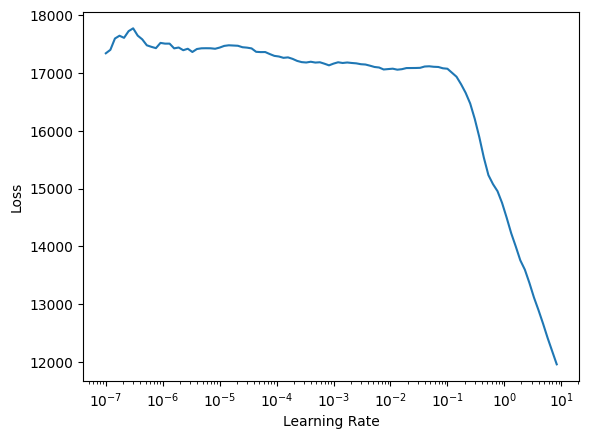

In [15]:
def find_lr(model, criterion, optimizer, train_data, start_lr=1e-7, end_lr=10, num_it=100):
    
    train_loader = DataLoader(train_data, batch_size=128)
    
    for param_group in optimizer.param_groups:
        param_group['lr'] = start_lr
    
    lrs = []
    losses = []
    
    lr_factor = (end_lr / start_lr) ** (1 / num_it)
    
    model.train()
    
    avg_loss = 0
    
    beta = 0.98
    
    for i, (inputs, targets) in enumerate(train_loader):
        if i >= num_it:
            break
        
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        inputs = torch.as_tensor(inputs)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()
        
        avg_loss = beta * avg_loss + (1 - beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta ** (i + 1))
        
        lrs.append(optimizer.param_groups[0]['lr'])
        losses.append(smoothed_loss)
        
        for param_group in optimizer.param_groups:
            param_group['lr'] *= lr_factor
    
    plt.plot(lrs, losses)
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    print(lrs[losses.index(min(losses))])

find_lr(model, criterion, optimizer, train_data=trainset)

In [16]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = 1.5,
    steps_per_epoch = len(train_loader),
    epochs = num_epochs
)

In [17]:
from torchinfo import summary

model = model
summary(model, input_size=(batch_size, 3, 160, 120))

Layer (type:depth-idx)                        Output Shape              Param #
U_Net                                         [128, 3, 160, 120]        --
├─Encoder: 1-1                                [128, 32, 20, 15]         --
│    └─DownSample_Stage: 2-1                  [128, 3, 160, 120]        --
│    │    └─ResBlock: 3-1                     [128, 3, 160, 120]        435
│    │    └─Transition_DownSample: 3-2        [128, 8, 80, 60]          38
│    └─DownSample_Stage: 2-2                  [128, 8, 80, 60]          --
│    │    └─ResBlock: 3-3                     [128, 8, 80, 60]          2,960
│    │    └─Transition_DownSample: 3-4        [128, 16, 40, 30]         160
│    └─DownSample_Stage: 2-3                  [128, 16, 40, 30]         --
│    │    └─ResBlock: 3-5                     [128, 16, 40, 30]         11,680
│    │    └─Transition_DownSample: 3-6        [128, 32, 20, 15]         576
├─ResBlock: 1-2                               [128, 32, 20, 15]         --
│    └─Dro

In [18]:
# PATH = r"D:\ProgrammingTools\Models\U_ResNet_Colourization.pth"
# model = U_Net(3, 32)
# model.load_state_dict(torch.load(PATH))

In [19]:
def train(model, criterion, optimizer, scheduler, train_loader, validate_loader, num_epochs, device):
    train_losses = torch.zeros(num_epochs).to(device)
    validate_losses = torch.zeros(num_epochs).to(device)
    model = model.to(device)
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for _ ,(inputs, targets) in enumerate(tqdm(train_loader)):
            inputs = inputs.to(device)
            targets = targets.to(device)
            inputs = torch.as_tensor(inputs)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * inputs.size(0)
        scheduler.step()

            
        train_loss /= len(train_loader.dataset)
        train_losses[epoch] = train_loss
        
        model.eval()
        validate_loss = 0
        
        with torch.no_grad():
            for _ ,(inputs, targets) in enumerate(tqdm(validate_loader)):
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                
                validate_loss += loss.item() * inputs.size(0)
        
        validate_loss /= len(validate_loader.dataset)
        validate_losses[epoch] = validate_loss
        
        print(f'Epoch {epoch+1}/{num_epochs}: Train Loss: {train_loss:.4f}, Validation Loss: {validate_loss:.4f}')
    
    return train_losses, validate_losses


In [20]:
train_losses, validate_losses = train(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device)

100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:17<00:00,  3.43it/s]


Epoch 1/30: Train Loss: 1110.5603, Validation Loss: 728.8839


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:15<00:00,  3.92it/s]


Epoch 2/30: Train Loss: 623.8916, Validation Loss: 567.3228


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:15<00:00,  3.96it/s]


Epoch 3/30: Train Loss: 506.5198, Validation Loss: 465.9813


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:15<00:00,  4.00it/s]


Epoch 4/30: Train Loss: 435.6847, Validation Loss: 407.3737


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.29it/s]


Epoch 5/30: Train Loss: 391.0178, Validation Loss: 383.4802


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.24it/s]


Epoch 6/30: Train Loss: 377.3879, Validation Loss: 377.0382


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.25it/s]


Epoch 7/30: Train Loss: 369.0970, Validation Loss: 375.5323


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.40it/s]


Epoch 8/30: Train Loss: 362.6854, Validation Loss: 386.3982


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.30it/s]


Epoch 9/30: Train Loss: 357.9048, Validation Loss: 353.6247


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.40it/s]


Epoch 10/30: Train Loss: 353.4599, Validation Loss: 388.4910


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.28it/s]


Epoch 11/30: Train Loss: 349.3500, Validation Loss: 347.2445


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.19it/s]


Epoch 12/30: Train Loss: 346.5350, Validation Loss: 344.9046


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.32it/s]


Epoch 13/30: Train Loss: 344.2879, Validation Loss: 343.3200


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.20it/s]


Epoch 14/30: Train Loss: 342.2471, Validation Loss: 347.8422


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.07it/s]


Epoch 15/30: Train Loss: 339.9125, Validation Loss: 344.1734


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.24it/s]


Epoch 16/30: Train Loss: 339.2890, Validation Loss: 335.5088


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.29it/s]


Epoch 17/30: Train Loss: 339.2318, Validation Loss: 361.8423


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.23it/s]


Epoch 18/30: Train Loss: 337.7840, Validation Loss: 337.2958


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.38it/s]


Epoch 19/30: Train Loss: 330.6563, Validation Loss: 333.6840


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.37it/s]


Epoch 20/30: Train Loss: 327.0155, Validation Loss: 373.2340


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.26it/s]


Epoch 21/30: Train Loss: 324.9327, Validation Loss: 325.5454


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.34it/s]


Epoch 22/30: Train Loss: 323.1625, Validation Loss: 326.6805


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:13<00:00,  4.42it/s]


Epoch 23/30: Train Loss: 321.7855, Validation Loss: 327.5472


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.28it/s]


Epoch 24/30: Train Loss: 320.4614, Validation Loss: 324.1312


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.31it/s]


Epoch 25/30: Train Loss: 319.0203, Validation Loss: 327.8389


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.31it/s]


Epoch 26/30: Train Loss: 318.0051, Validation Loss: 324.7441


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.28it/s]


Epoch 27/30: Train Loss: 316.9379, Validation Loss: 318.7047


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.32it/s]


Epoch 28/30: Train Loss: 316.2455, Validation Loss: 326.9371


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.20it/s]


Epoch 29/30: Train Loss: 315.1229, Validation Loss: 319.1085


100%|██████████████████████████████████████████████████████████████████████████████████| 61/61 [00:14<00:00,  4.22it/s]

Epoch 30/30: Train Loss: 313.5495, Validation Loss: 339.0976


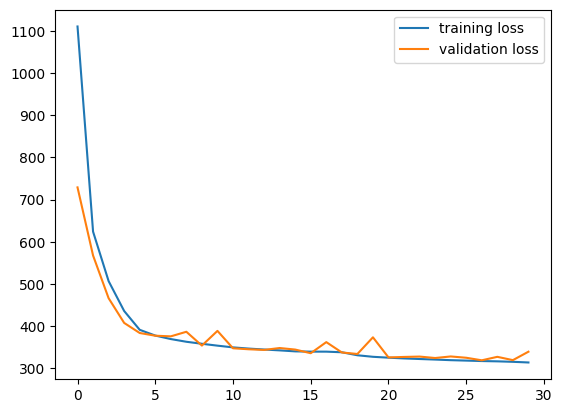

In [21]:
def plot_arrays(array1, name1, array2, name2): 
    array1 = array1.cpu().numpy()
    array2 = array2.cpu().numpy()
    
    plt.plot(array1, label=name1)
    plt.plot(array2, label=name2)
    
    plt.legend()
    plt.show()

plot_arrays(train_losses, 'training loss', validate_losses, 'validation loss')

In [22]:
PATH = r"D:\ProgrammingTools\Models\U_ResNet_Colourization.pth"
torch.save(model.state_dict(), PATH)

In [23]:
def test_and_plot_samples(test_loader, model, criterion):
    model = model.to(device)
    model.eval()

    total_loss = 0.0

    input_images = []
    colorized_images = []
    target_images = []

    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = criterion(outputs, targets)
            total_loss += loss.item()

            if i < 5:
                input_images.append(inputs[0].cpu().numpy())
                colorized_images.append((torch.clamp(outputs[0], 0, 255)).cpu().numpy())
                target_images.append(targets[0].cpu().numpy())

    avg_loss = total_loss / len(test_loader)

    print(f'Average Loss: {avg_loss}')

    fig, axs = plt.subplots(5, 3, figsize=(15, 25))

    for i in range(5):
        input_img = np.transpose(input_images[i], (1, 2, 0))
        input_img = (input_img ).astype(np.uint8)
        axs[i, 0].imshow(input_img)
        axs[i, 0].set_title('Input')

        colorized_img = np.transpose(colorized_images[i], (1, 2, 0))
        colorized_img = (colorized_img).astype(np.uint8)
        axs[i, 1].imshow(colorized_img)
        axs[i, 1].set_title('Prediction')

        target_img = np.transpose(target_images[i], (1, 2, 0))
        target_img = (target_img).astype(np.uint8)
        axs[i, 2].imshow(target_img)
        axs[i, 2].set_title('Target')

    plt.show()

Average Loss: 335.1438378506019


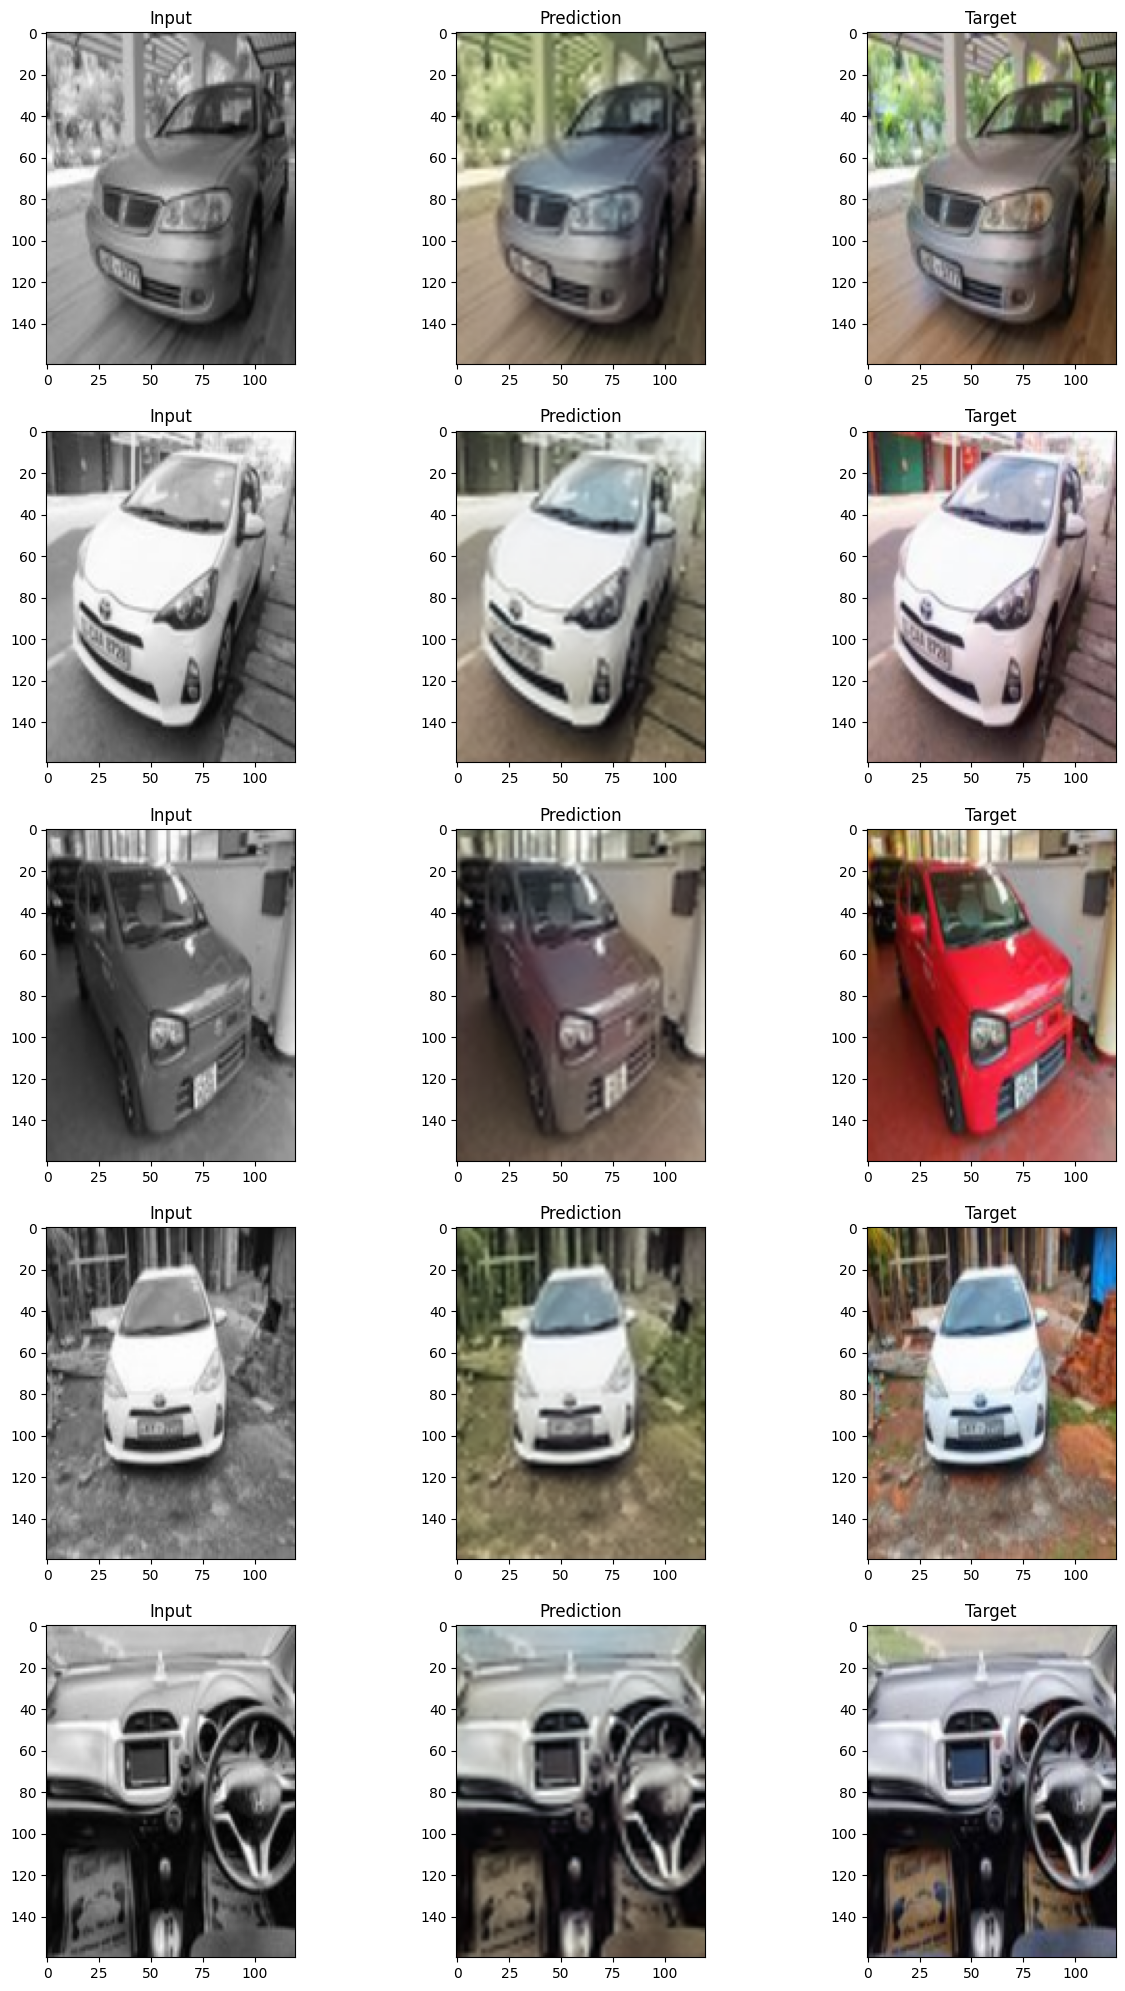

In [24]:
test_and_plot_samples(test_loader, model, criterion)